In [158]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn.metrics import confusion_matrix, classification_report

from theta import rtbm, minimizer

import theta.layers as layers
import theta.model as mdl

import warnings
warnings.filterwarnings('ignore')

from theta.costfunctions import mse, crossentropy
import h5py
from sklearn import metrics

In [149]:
# Load jet dataset
jet_train = h5py.File('~/data/train_no_pile_10000000.h5', 'r')
jet_test = h5py.File('~/data/test_no_pile_5000000.h5', 'r')

# Prepare data (normalized onto [0,1])
n = 10000
m = 32
Y_train = np.array(jet_train['targets'][0:n,0], dtype=np.int32)
norm = np.max(jet_train['features'][0:n,0])
X_train = jet_train['features'][0:n,0].reshape(n,m*m) / norm

Y_test = np.array(jet_test['targets'][0:n/2,0], dtype=np.int32)
X_test = jet_test['features'][:n/2,0].reshape(n/2,m*m) / norm

1


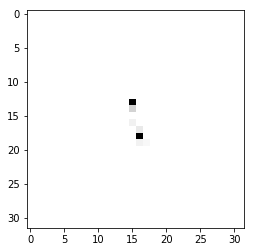

In [150]:
# Visualize individual pics
i=0
print(Y_train[i])
I=np.reshape(X_train[i], (m,m))
plt.imshow(I, interpolation='nearest',  cmap='gray_r')
plt.show()

# Logistic regression baseline

In [159]:
# Logistic regression baseline
logreg = linear_model.LogisticRegression(multi_class='multinomial',solver='lbfgs')

logreg.fit(X_train,Y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [202]:
# On train set

P=logreg.predict(X_train)

print(classification_report(Y_train,P))
print(confusion_matrix(Y_train, P))

print('AUC: %f' % metrics.roc_auc_score(Y_train, P))

             precision    recall  f1-score   support

          0       0.78      0.83      0.81      5000
          1       0.82      0.77      0.79      5000

avg / total       0.80      0.80      0.80     10000

[[4139  861]
 [1142 3858]]
AUC: 0.799700


In [203]:
# On test set
P=logreg.predict(X_test)

print(classification_report(Y_test,P))
print(confusion_matrix(Y_test, P))
print('AUC: %f' % metrics.roc_auc_score(Y_test, P))

             precision    recall  f1-score   support

          0       0.80      0.83      0.81      2564
          1       0.82      0.77      0.79      2436

avg / total       0.81      0.80      0.80      5000

[[2136  428]
 [ 549 1887]]
AUC: 0.803852


# Linear regression base line

In [169]:
linreg = linear_model.LinearRegression()

linreg.fit(X_train,Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [204]:
# On train set

P=np.round(linreg.predict(X_train))

print(classification_report(Y_train,P))
print(confusion_matrix(Y_train, P))
print('AUC: %f' % metrics.roc_auc_score(Y_train, P))

             precision    recall  f1-score   support

       -2.0       0.00      0.00      0.00         0
       -1.0       0.00      0.00      0.00         0
        0.0       0.85      0.85      0.85      5000
        1.0       0.85      0.85      0.85      5000

avg / total       0.85      0.85      0.85     10000

[[   0    0    0    0]
 [   0    0    0    0]
 [   1    4 4238  757]
 [   0    0  769 4231]]
AUC: 0.847477


In [205]:
# On test set
P=linreg.predict(X_test)

print(classification_report(Y_test,P))
print(confusion_matrix(Y_test, P))
print('AUC: %f' % metrics.roc_auc_score(Y_test, P))

ValueError: Mix type of y not allowed, got types set(['binary', 'continuous'])

# Linear regression via CMA

In [123]:
M = mdl.Model()
M.add(layers.Linear(m*m,1))

minim = minimizer.CMA(False)
sol=minim.train(mse, M, np.transpose(X_train), np.transpose(Y_train), maxiter=1000)

CMA on 1 cpu(s) enabled
(12_w,24)-aCMA-ES (mu_w=7.0,w_1=24%) in dimension 1025 (seed=788804, Thu Dec  7 10:46:07 2017)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     24 2.570257675157519e-01 1.0e+00 9.93e-01  1e+00  1e+00 0:00.0
    2     48 2.896666284201821e-01 1.0e+00 9.86e-01  1e+00  1e+00 0:00.5
    3     72 2.695416186667523e-01 1.0e+00 9.79e-01  1e+00  1e+00 0:00.9
   10    240 3.089261601986672e-01 1.0e+00 9.40e-01  9e-01  9e-01 0:03.9
   20    480 3.932493940452424e-01 1.0e+00 8.98e-01  9e-01  9e-01 0:08.1
   31    744 4.333357706183462e-01 1.0e+00 8.64e-01  9e-01  9e-01 0:13.2
   46   1104 4.983083471678758e-01 1.0e+00 8.28e-01  8e-01  8e-01 0:19.6
   63   1512 4.472394351818508e-01 1.0e+00 7.98e-01  8e-01  8e-01 0:26.8
   82   1968 3.974324872581882e-01 1.0e+00 7.72e-01  8e-01  8e-01 0:35.3
  100   2400 3.676499756380006e-01 1.0e+00 7.56e-01  8e-01  8e-01 0:42.9
  123   2952 3.436848524698505e-01 1.0e+00 7.42e-01  7e-01  7e-01 0:53.0
  149 

KeyboardInterrupt: 

In [206]:
# On train set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_train)))))


print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_train, P.T))

             precision    recall  f1-score   support

          0       0.79      0.75      0.77      5000
          1       0.76      0.80      0.78      5000

avg / total       0.78      0.78      0.78     10000

[[3742 1258]
 [ 980 4020]]
AUC: 0.776200


In [207]:
# On test set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_test)))))

print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_test, P.T))

             precision    recall  f1-score   support

          0       0.81      0.76      0.78      2564
          1       0.76      0.81      0.78      2436

avg / total       0.78      0.78      0.78      5000

[[1938  626]
 [ 469 1967]]
AUC: 0.781661


# Linear regression via SGD

Progress: |████████████████████| 100.0% | iteration 1000 in 137.26(s) | cost = 0.136394 | val = 0.000000


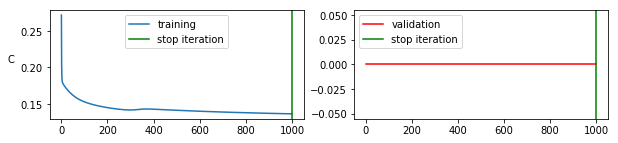

In [126]:
M = mdl.Model()
M.add(layers.Linear(m*m,100))
M.add(layers.Linear(100,1))

#M.add(layers.NonLinear(784,3))
#M.add(layers.NonLinear(3,3))
#M.add(layers.Linear(10,1))

minim = minimizer.SGD()
sol=minim.train(mse, M, np.transpose(X_train), Y_train.reshape(1,len(Y_train)), lr=0.1, maxiter=1000, batch_size=1000)

#minim = minimizer.BFGS()
#sol=minim.train(mse(), M, np.transpose(X_train), Y_train.reshape(1,len(Y_train)), maxiter=1000)

In [208]:
# On train set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_train)))))

print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_train, P.T))

             precision    recall  f1-score   support

          0       0.79      0.75      0.77      5000
          1       0.76      0.80      0.78      5000

avg / total       0.78      0.78      0.78     10000

[[3742 1258]
 [ 980 4020]]
AUC: 0.776200


In [209]:
# On test set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_test)))))

print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_test, P.T))

             precision    recall  f1-score   support

          0       0.81      0.76      0.78      2564
          1       0.76      0.81      0.78      2436

avg / total       0.78      0.78      0.78      5000

[[1938  626]
 [ 469 1967]]
AUC: 0.781661


# E(h|v) via SGD

Progress: |████████████████████| 100.0% | iteration 1000 in 164.40(s) | cost = 0.131634 | val = 0.000000


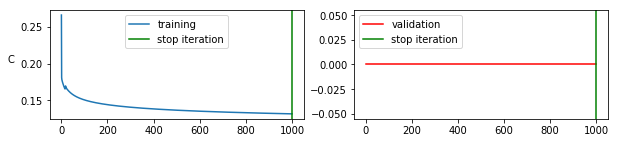

In [139]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(m*m,1))
#M.add(layers.DiagExpectationUnitLayer(10,1))

minim = minimizer.SGD()
sol=minim.train(mse, M, np.transpose(X_train), Y_train.reshape(1,Y_train.shape[0]),lr=10,momentum=0.1, nesterov=True, maxiter=1000, batch_size=1000)

In [210]:
# On train set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_train)))))


print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_train, P.T))

             precision    recall  f1-score   support

          0       0.79      0.75      0.77      5000
          1       0.76      0.80      0.78      5000

avg / total       0.78      0.78      0.78     10000

[[3742 1258]
 [ 980 4020]]
AUC: 0.776200


In [211]:
# On test set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_test)))))

print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_test, P.T))

             precision    recall  f1-score   support

          0       0.81      0.76      0.78      2564
          1       0.76      0.81      0.78      2436

avg / total       0.78      0.78      0.78      5000

[[1938  626]
 [ 469 1967]]
AUC: 0.781661


# E(h|v) via CMA

In [144]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(m*m,3, phase=1))
M.add(layers.DiagExpectationUnitLayer(3,1, phase=1))

minim = minimizer.CMA(False)
sol=minim.train(mse, M, np.transpose(X_train), np.transpose(Y_train), maxiter=1000)

CMA on 1 cpu(s) enabled
(14_w,28)-aCMA-ES (mu_w=8.1,w_1=21%) in dimension 3083 (seed=670192, Thu Dec  7 10:55:21 2017)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     28 4.405045714096039e-01 1.0e+00 1.60e+00  2e+00  2e+00 0:00.2
    2     56 3.720052531398204e-01 1.0e+00 1.59e+00  2e+00  2e+00 0:01.7
    3     84 2.842611871472150e-01 1.0e+00 1.59e+00  2e+00  2e+00 0:03.2
    6    168 2.568303215719469e-01 1.0e+00 1.57e+00  2e+00  2e+00 0:07.6
    9    252 2.011688507546809e-01 1.0e+00 1.56e+00  2e+00  2e+00 0:11.9
   13    364 1.973097080840297e-01 1.0e+00 1.55e+00  2e+00  2e+00 0:17.8
   18    504 1.871702979851027e-01 1.0e+00 1.53e+00  2e+00  2e+00 0:25.2
   22    616 1.915920605903696e-01 1.0e+00 1.52e+00  2e+00  2e+00 0:35.7
   28    784 2.027028517201159e-01 1.0e+00 1.50e+00  1e+00  1e+00 0:44.7
   35    980 1.871250111552502e-01 1.0e+00 1.48e+00  1e+00  1e+00 0:55.1
   42   1176 1.895502301288206e-01 1.0e+00 1.46e+00  1e+00  1e+00 1:05.6
   47 

In [213]:
# On train set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_train)))))


print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_train, P.T))

             precision    recall  f1-score   support

          0       0.79      0.75      0.77      5000
          1       0.76      0.80      0.78      5000

avg / total       0.78      0.78      0.78     10000

[[3742 1258]
 [ 980 4020]]
AUC: 0.776200


In [214]:
# On test set
P=np.abs(np.round(np.real(M.predict(np.transpose(X_test)))))

print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))
print('AUC: %f' % metrics.roc_auc_score(Y_test, P.T))

             precision    recall  f1-score   support

          0       0.81      0.76      0.78      2564
          1       0.76      0.81      0.78      2436

avg / total       0.78      0.78      0.78      5000

[[1938  626]
 [ 469 1967]]
AUC: 0.781661
